### Task 1: Import Libraries

In [52]:
import math
import os
import pickle
import re
from collections import defaultdict
from pathlib import Path

import gradio as gr 
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
import torch
import torchvision
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from torchvision.models import convnext_small
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.text import ROUGEScore
from torchvision.transforms import Normalize, ToPILImage, ToTensor
from transformers import GPT2Tokenizer


### Task 2: Set Random Seed

In [19]:
seed = 42

torch.manual_seed(seed)

np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

### Task 3: Load and Visualize the Data

Caption 0: A kayaker gets wet in the rapids .
Caption 1: A kayaker in a green boat paddles through the rapids .
Caption 2: A man in black with a helmet is water rafting in a green canoe .
Caption 3: One man in a green kayak paddling through the water .
Caption 4: This man is kayaking in whitewater .


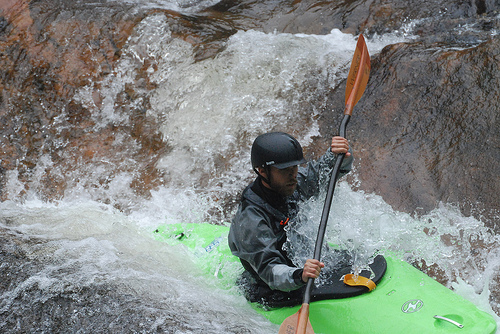

In [20]:
img_dir = "/usercode/flickr-8k/images"
text_dir = "/usercode/flickr-8k/text"

captions = pd.read_csv(Path(text_dir, "Flickr8k.token.txt"), sep="\t", names=["image_name", "caption"])

images = os.listdir(img_dir)
index = np.random.randint(0, len(images))
selected_file = images[index]

selected_captions = captions[captions["image_name"].apply(lambda x: x[: -2]) == selected_file]["caption"].tolist()
for idx, caption in enumerate(selected_captions):
    print(f"Caption {idx}: {caption}")

Image.open(Path(img_dir, selected_file))

### Task 4: Create a Transformation Function

In [21]:
class ResizePadTransform:
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, image):
        width, height = image.size
        aspect_ratio = width / height

        if width > height:
            new_width = self.target_size
            new_height = int(self.target_size / aspect_ratio)
        else:
            new_height = self.target_size
            new_width = int(self.target_size * aspect_ratio)

        resize_transform = transforms.Resize((new_height, new_width))

        resized_image = resize_transform(image)

        pad_width = self.target_size - new_width
        pad_height = self.target_size - new_height

        pad_left = pad_width // 2
        pad_right = pad_width - pad_left

        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top

        if pad_width % 2 != 0:
            pad_right += 1
        if pad_height % 2 != 0:
            pad_bottom += 1

        padding_transform = transforms.Pad((pad_left, pad_top, pad_right, pad_bottom))

        padded_resized_image = padding_transform(resized_image)

        return padded_resized_image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

tfms = transforms.Compose([
    ResizePadTransform(224),
    ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


### Task 5: Create a Tokenizer

In [22]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

tokenizer.add_special_tokens(
    {"bos_token": "<|startoftext|>", "unk_token": "<|unk|>", "pad_token": "[PAD]"}
)

print(tokenizer.encode("A cat is playing."))

print(tokenizer.decode(tokenizer.encode("This is a cat playing.")))

[32, 3797, 318, 2712, 13]
This is a cat playing.


### Task 6: Transform the Dataset

In [23]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, data_split, transform=None, tokenizer=None, max_len=50, phase="train"):
        self.img_folder = Path(root_dir, "images")
        self.text_folder = Path(root_dir, "text")

        split_file = Path(self.text_folder, f"Flickr_8k.{data_split}Images.txt")

        self.images = pd.read_csv(split_file, names=["image_name"])

        self.captions = pd.read_csv(Path(self.text_folder, "Flickr8k.token.txt"), names=["image_name", "caption"], sep="\t")

        self.transform = transform
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.phase = phase

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.phase == "train":
            caption_row = self.captions.iloc[idx]
            caption = caption_row["caption"]
            caption = f"{self.tokenizer.bos_token} {caption} {self.tokenizer.eos_token}"
            caption = self.tokenizer.encode(caption)

            pad_tokens = self.max_len - len(caption) + 1
            caption += pad_tokens * [self.tokenizer.pad_token_id]
            caption = torch.tensor(caption)

            image_name = caption_row["image_name"][:-2]
            image = Image.open(Path(self.img_folder, image_name))
            image = self.transform(image)

        else:
            image_name = self.images["image_name"][idx]
            image = Image.open(Path(self.img_folder, image_name))
            image = self.transform(image)

            caption = self.captions[self.captions["image_name"].str.contains(image_name)]["caption"].tolist()

        return {"image": image, "caption": caption, "image_name": image_name}

train_dataset = CustomImageDataset(root_dir = "/usercode/flickr-8k", data_split = "train", transform=tfms, tokenizer=tokenizer)
eval_dataset = CustomImageDataset(root_dir = "/usercode/flickr-8k", data_split = "dev", transform=tfms, tokenizer=tokenizer)
test_dataset = CustomImageDataset(root_dir = "/usercode/flickr-8k", data_split = "test", transform=tfms, tokenizer=tokenizer)

print(len(train_dataset), len(eval_dataset), len(test_dataset))

print(train_dataset[100]["caption"])

print(tokenizer.decode(train_dataset[100]["caption"].tolist()))

180 30 30
tensor([50257,    32,  2576,   351,   257,  2266, 14335,   269,   560,   278,
          257,  1256,   286, 17182,   764,   220, 50256, 50258, 50258, 50258,
        50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
        50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
        50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
        50258])
<|startoftext|> A girl with a red helmet carying a lot of rope. <|endoftext|> [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


### Task 7: Create a DataLoader

In [24]:
BATCH_SIZE = 8

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)

eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(len(train_dataloader))
print(len(eval_dataloader))
print(len(test_dataloader))

23
4
4


### Task 8: Prepare ConvNeXt Model

In [25]:
def get_cnn_model():
    model = convnext_small(weights=torchvision.models.convnext.ConvNeXt_Small_Weights.IMAGENET1K_V1)
    
    model = nn.Sequential(*list(model.children())[:-2])

    return model

model = get_cnn_model()

print(model(torch.rand(8, 3, 224, 224)).shape)

torch.Size([8, 768, 7, 7])


### Task 9: Create a Model using ConvNeXt and Transformer Decoder

In [26]:
# sinusoidal PositionalEncoding class

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout = 0.1, max_len = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2)
                             * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [44]:
NUM_LAYERS = 6
EMB_DIM = 768
NHEAD = 8
DIM_FEEDFORWARD = 2048
DROPOUT = 0.1
ACTIVATION = "gelu"

class TransformerDecoder(nn.Module):
    def __init__ (
        self,
        emb_size,
        nhead,
        num_decoder_layers,
        tgt_vocab_size,
        dim_feedforward,
        dropout,
        activation,
    ):
        super(TransformerDecoder, self).__init__()
        self.emb_size = emb_size
        self.embedding = nn.Embedding(tgt_vocab_size, emb_size)
        self.text_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=emb_size,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                activation=activation,
            ),
            num_decoder_layers,
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

        self.init_weights()

    def init_weights(self):
        range = 0.1
        self.embedding.weight.data.uniform_(-range, range)
        self.generator.bias.data.zero_()
        self.generator.weight.data.uniform_(-range, range)

    def forward(self, src_emb, tgt_tokens, tgt_mask, tgt_padding_mask):
        B, D, H, W = src_emb.shape
        src_emb = src_emb.reshape(B, D, -1).permute(2, 0, 1)
        src_emb = self.positional_encoding(src_emb)

        tgt_emb = self.embedding(tgt_tokens) * math.sqrt(self.emb.size)
        tgt_emb = tgt_emb.permute(1, 0, 2)
        tgt_emb = self.positional_encoding(tgt_emb)

        outs = self.text_decoder(
            tgt_emb, src_emb, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask
        )

        return self.generator(outs)

    def generate(self, img_ft, tgt_tokens):
        src_emb = self.positional_encoding(img_ft)
        tgt_emb = self.embedding(tgt_tokens) * math.sqrt(self.emb_size)
        tgt_emb = tgt_emb.permute(1, 0, 2)
        tgt_emb = self.positional_encoding(tgt_emb)

        outs = self.text_decoder(tgt_emb, src_emb)

        return self.generator(outs)

class CaptionModel(nn.Module):
    def __init__(
        self,
        emb_size,
        nhead,
        num_decoder_layers,
        tgt_vocab_size,
        dim_feedforward,
        dropout,
        activation,
    ):
        super(CaptionModel, self).__init__()

        self.image_encoder = get_cnn_model()
        self.text_decoder = TransformerDecoder(
            emb_size,
            nhead,
            num_decoder_layers,
            tgt_vocab_size,
            dim_feedforward,
            dropout,
            activation
        )
    
    def forward(self, img_op, tgt_tokens, tgt_mask, tgt_padding_mask):
        src_emb = self.image_encoder(img_op)
        text_op = self.text_decoder(src_emb, tgt_tokens, tgt_mask, tgt_padding_mask)

        return text_op

model = CaptionModel(
    emb_size=EMB_DIM,
    nhead=NHEAD,
    num_decoder_layers=NUM_LAYERS,
    tgt_vocab_size=len(tokenizer),
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT,
    activation=ACTIVATION,
)

### Task 10: Set the Loss function

In [45]:
criterion = CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

### Task 11: Set the Optimizer

In [46]:
NUM_EPOCHS = 50
transformer_learning_rate = 1e-4
cnn_learning_rate = 1e-5

optimizer_cnn = torch.optim.AdamW(
    model.image_encoder.parameters(), lr=cnn_learning_rate
)

optimizer_transformer = torch.optim.AdamW(
    model.text_decoder.parameters(), lr=transformer_learning_rate
)

scheduler_cnn = CosineAnnealingLR(optimizer_cnn, T_max=NUM_EPOCHS)

scheduler_transformer = CosineAnnealingLR(optimizer_transformer, T_max=NUM_EPOCHS)

### Task 12: Train the Model

In [47]:
# code to generate a mask for the target to ignore the future sequences

def create_mask(src, tgt, pad_idx):
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)

    tgt_padding_mask = (tgt == pad_idx)
    return tgt_mask, tgt_padding_mask


def generate_square_subsequent_mask(sz, device="cpu"):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float(
        '-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [48]:
NUM_EPOCHS = 35

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(DEVICE)

exp_dir = "caption_generation_experiment"
writer = SummaryWriter(exp_dir)

checkpoint_epoch = 5

def train():
    for e in range(NUM_EPOCHS):
        model.train()
        train_running_loss = 0.0
        i = 0

        for idx, data in enumerate(train_dataloader):
            imgs = data["image"].to(device=DEVICE)
            target = data["caption"].to(device=DEVICE)

            target_in = target[:, :-1]
            target_out = target[:, 1:]

            model.zero_grad(set_to_none=True)

            tgt_mask, tgt_padding_mask = create_mask(
                imgs, target_in, pad_idx=tokenizer.pad_token_id
            )

            logits = model(
                imgs, target_in, tgt_mask.to(DEVICE), tgt_padding_mask.to(DEVICE)
            )

            T, B, D = logits,shape

            loss = criterion(
                logits.permute(1,0, 2).reshape(T * B, D),
                target_out.reshape(T * B),
            )

            # Log loss to TensorBoard
            writer.add_scalar("loss/train", loss, (e * NUM_EPOCHS + idx))

            # Backpropagation
            loss.backward()
            optimizer_cnn.step()
            optimizer_transformer.step()

            # Accumulate batch loss
            train_running_loss += loss.item()
            i += 1  # Increment batch counter

        # Step the learning rate scheduler after each epoch
        scheduler_cnn.step()
        scheduler_transformer.step()

        # Calculate and log average training loss for the epoch
        train_epoch_loss = train_running_loss / i
        writer.add_scalar("epoch_loss/train", train_epoch_loss, e)
        print(f"Train loss after epoch {e+1}: {train_epoch_loss}")

        # Run evaluation every `checkpoint_epoch` epochs
        if (e + 1) % checkpoint_epoch == 0:
            model.eval()  # Set model to evaluation mode
            eval_running_loss = 0.0
            i = 0  # Reset batch counter

            with torch.no_grad():  # Disable gradient computation for evaluation
                for idx, data in enumerate(eval_dataloader):
                    imgs = data["image"].to(device=DEVICE)
                    target = data["caption"].to(device=DEVICE)

                    target_in = target[:, :-1]
                    target_out = target[:, 1:]

                    tgt_mask, tgt_padding_mask = create_mask(
                        imgs, target_in, pad_idx=tokenizer.pad_token_id
                    )

                    logits = model(
                        imgs, target_in, tgt_mask.to(DEVICE), tgt_padding_mask.to(DEVICE)
                    )

                    T, B, D = logits.shape

                    loss = criterion(
                        logits.permute(1, 0, 2).reshape(T * B, D),
                        target_out.reshape(T * B),
                    )

                    eval_running_loss += loss.item()
                    i += 1

                # Calculate and log evaluation loss
                eval_epoch_loss = eval_running_loss / i
                writer.add_scalar("epoch_loss/eval", eval_epoch_loss, e)
                print(f"Eval loss after epoch {e+1}: {eval_epoch_loss}")

            # Save model checkpoint
            torch.save(model.state_dict(), f"{exp_dir}/model_epoch_{e}.pt")

### Task 13: Load Pretrained Model

In [49]:
model_state = torch.load("/model_state_34_jan31.pt", map_location=DEVICE)
# Load the saved parameters into the model
model.load_state_dict(model_state)
# Set the model to evaluation mode (disables dropout and batch normalization layers)
model = model.eval()

### Task 14: Evaluate the Model

In [50]:
def eval_collate(batch_data):
    # Extract the image, caption, and image name from the first item in the batch
    images = batch_data[0]["image"].unsqueeze(0)  # Add batch dimension to image
    caption = batch_data[0]["caption"]
    image_name = batch_data[0]["image_name"]

    # Return the batch as a dictionary
    data = {"image": images, "caption": caption, "image_name": image_name}

    return data

# Create an evaluation dataset for testing (uses 'test' phase)
eval_dataset = CustomImageDataset(
    root_dir="/usercode/flickr-8k",
    data_split="dev",
    transform=tfms,
    tokenizer=tokenizer,
    phase="test",
)

# Define the DataLoader with a batch size of 1 and custom collation function
eval_dataloader = DataLoader(eval_dataset, batch_size=1, collate_fn=eval_collate)

# Dictionary to store the prediction results
pred_results = defaultdict(list)

# Set the model to evaluation mode (disables dropout and batch normalization layers)
model = model.eval()

# Disable gradient computation for evaluation
with torch.no_grad():
    for idx, data in enumerate(eval_dataloader):
        imgs = data["image"].to(DEVICE)  # Move images to the appropriate device
        references = data["caption"]  # Ground-truth captions
        image_name = data["image_name"]  # Image name

        # Extract image features using the CNN encoder
        img_ftr = model.image_encoder(imgs).reshape(1, EMB_DIM, -1).permute(2, 0, 1)

        # Initialize predicted token list with the beginning-of-sequence (BOS) token
        pred_tokens = [tokenizer.bos_token_id]

        # Generate caption token-by-token until EOS token is reached or max length is exceeded
        while (
            pred_tokens[-1] != tokenizer.eos_token_id
            if len(pred_tokens) > 1
            else True
        ) and len(pred_tokens) <= 50:
            cur_tokens = torch.tensor(pred_tokens).unsqueeze(0).to(DEVICE)  # Convert to tensor
            pred = model.text_decoder.generate(img_ftr, cur_tokens)[-1]  # Get the next predicted token

            # Append predicted token (highest probability) to the sequence
            pred_tokens.append(pred.detach().cpu().argmax(-1).item())

        # Decode the generated tokens into text
        pred_caption = tokenizer.decode(pred_tokens)

        # Store the predictions and references
        pred_results["image_name"].append(image_name)
        pred_results["prediction"].append(pred_caption)
        pred_results["references"].append(references)

# Clean the generated predictions by removing special tokens
predictions = [x.replace("<|startoftext|>", "").replace("<|endoftext|>", "") for x in pred_results["prediction"]]
references = pred_results["references"]  # Ground-truth references

# Compute ROUGE-L score to evaluate the quality of generated captions
rouge_score = ROUGEScore()
rouge_score = rouge_score(predictions, references)["rougeL_fmeasure"]

# Print the final ROUGE-L score
print(rouge_score)

tensor(0.4329)


### Task 15: Deploy the Model using Gradio

In [53]:
def generate_caption(img_ftr, tokens):
    # Generate the next token using the model
    pred = model.generate(img_ftr, torch.tensor(tokens).unsqueeze(0))
    
    # Append the predicted token with the highest probability
    tokens.append(pred.argmax(-1).item())
    
    return tokens

# Function to predict the caption for a given image
def predict(img):
    tokens = [tokenizer.bos_token_id]  # Start with the beginning-of-sequence (BOS) token
    
    # Apply image transformations and add batch dimension
    img = tfms(img).unsqueeze(0)
    
    # Extract image features using the image encoder
    img_ftr = model.image_encoder(img).reshape(1, EMB_DIM, -1).permute(2, 0, 1)
    
    # Apply positional encoding to the image features
    img_ftr = model.text_decoder.positional_encoding(img_ftr)

    c = 0  # Counter to prevent infinite loops
    while (
        tokens[-1] != tokenizer.eos_token_id if len(tokens) > 1 else True
    ) and c <= 50:  # Continue until EOS token is generated or max length is reached
        # Generate the next token
        pred = model.text_decoder.generate(img_ftr, torch.tensor(tokens).unsqueeze(0))[-1]
        
        # Append the predicted token to the sequence
        tokens.append(pred.argmax(-1).item())
        
        c += 1  # Increment the counter

    # Decode the token sequence into a caption, removing special tokens
    return (
        tokenizer.decode(tokens)
        .replace(tokenizer.bos_token, "")
        .replace(tokenizer.eos_token, "")
        .strip()
    )

# Define the directory containing images
image_dir = "/usercode/flickr-8k/images"

# List of example images for demonstration
examples = [
    Path(image_dir, "1377668044_36398401dd.jpg"),
    Path(image_dir, "2094323311_27d58b1513.jpg"),
    Path(image_dir, "299181827_8dc714101b.jpg")
]

# Set model to evaluation mode
model = model.eval()

# Disable gradient computation for inference
with torch.no_grad():
    # Create a Gradio interface for interactive caption generation
    demo = gr.Interface(
        fn=predict,  # Function to generate captions
        inputs=gr.Image(type="pil"),  # Accepts an image as input
        outputs="text",  # Outputs generated text
        examples=examples  # Predefined example images
    )
    
    # Launch the Gradio interface with public sharing enabled
    demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
IMPORTANT: You are using gradio version 4.13.0, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://9f7a5e29281990e7c4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
